In [351]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
import seaborn as sns
import torch

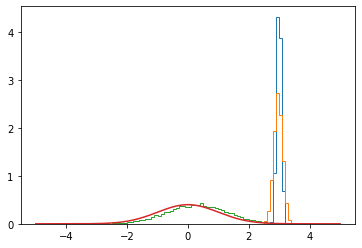

In [455]:
noise_schedule = np.linspace(0.0001,0.03,300)
def corrupt(X,t, return_trajectory = False):
    trajectory = [X]
    def _corrupt_step(X,var):
        alpha = 1-var
        X = np.random.normal(np.sqrt(alpha)*X,np.sqrt(1-alpha), size = X.shape)
        return X
    for step in range(t):
        X = _corrupt_step(X,noise_schedule[step])
        trajectory.append(X)
    if return_trajectory:
        return torch.stack([torch.FloatTensor(x) for x in trajectory])
    return torch.FloatTensor(X)

def samples(value,N):
    return value*torch.ones(N,1)

bins = np.linspace(-5,5,101)


plt.hist(corrupt(samples(3,10000),10).ravel(),bins = bins, histtype = 'step', density=True);
plt.hist(corrupt(samples(3,10000),20).ravel(),bins = bins, histtype = 'step', density=True);
plt.hist(corrupt(samples(3,10000),300).ravel(),bins = bins, histtype = 'step', density=True);

xi = np.linspace(-5,5,1001)
yi = sps.norm(0,1).pdf(xi)
plt.plot(xi,yi)

In [497]:
x0 = 3
trajs = corrupt(samples(x0,1000000),300, return_trajectory=True)

In [498]:
# plt.plot(t[:,:,0], c = 'k', alpha = 0.2);

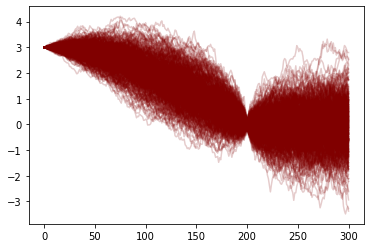

In [499]:
def abc(trajs,value,step = -1, eps = 0.1):
    filt = (value-eps < trajs[step,:,0]) & (trajs[step,:,0] < value+eps)
    return filt

# plt.plot(t[:,:,0], c = 'k', alpha = 0.05);
plt.plot(trajs[:,abc(trajs,0,step = 200, eps = 0.001),0], c = 'maroon', alpha = 0.2);

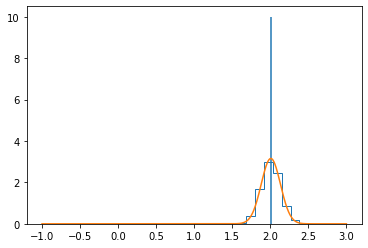

In [528]:
xt = 2.0
t = 160
conditioned = trajs[t-1,abc(trajs,xt,step = t, eps = 0.005),0]
plt.hist(conditioned, bins = np.linspace(-1,2.5,31), histtype = 'step', density=True);
mean,sigma = get_mean_sigma(xt,x0,t)
xi = np.linspace(-1,3,1001)
yi = sps.norm(mean,sigma).pdf(xi)
plt.vlines(mean,0,10)
plt.plot(xi,yi)

In [512]:
def get_mean_sigma(xt,x0,t):
    step = t
    alpha = 1-noise_schedule
    alpha_t = alpha[step]
    alphabar_t = alpha[:step].prod()

    alpha_t1 = alpha[step-1]
    alphabar_t1 = alpha[:step-1].prod()
    f1 = np.sqrt(alpha_t)*(1-alphabar_t1)/(1-alphabar_t)
    f2 = np.sqrt(alphabar_t1)*(1-alpha_t)/(1-alphabar_t)
    xmean = f1*xt + f2*x0
    sigma2 = (1-alphabar_t1)/(1-alphabar_t)*(1-alpha_t)
    return xmean,np.sqrt(sigma2)